In [1]:
# Munging imports

import pandas as pd
import numpy as np

# Visualiztion imports
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import shap
shap.initjs()

# Modeling imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, auc, confusion_matrix
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, roc_curve, classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, tree, naive_bayes
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
PERM_VISA = pd.read_csv("applications_4.csv", index_col = 0)

In [4]:
PERM_VISA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91704 entries, 0 to 91703
Data columns (total 21 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Application Declined                                    91704 non-null  int64  
 1   No of employees for company                             91704 non-null  float64
 2   Skill level (1-4)                                       91704 non-null  int64  
 3   Specific skills listed                                  91704 non-null  int64  
 4   Decision made during Trump administration               91704 non-null  int64  
 5   Decision made during Biden administration               91704 non-null  int64  
 6   Days between application and decision                   91704 non-null  int64  
 7   Salary offer                                            91704 non-null  int64  
 8   FAANG or other prominent employer   

In [5]:
X, y = PERM_VISA.drop(["Application Declined"], axis=1), PERM_VISA["Application Declined"]
X_mid, X_test, y_mid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_mid, y_mid, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)

### Model Hypertuning and Further Comparison

In [8]:
# Logistic Regression

lr = LogisticRegression(class_weight = "balanced")
lr.fit(X_train_sc, y_train)
lr_pred = lr.predict(X_val_sc)
lr_confusion = confusion_matrix(y_val, lr_pred)

lr_ac = lr.score(X_val_sc, y_val)
lr_precision = precision_score(y_val, lr_pred)
lr_recall = recall_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred)

print(classification_report(y_val, lr_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     13631
           1       0.25      0.78      0.38      1042

    accuracy                           0.82     14673
   macro avg       0.62      0.80      0.64     14673
weighted avg       0.93      0.82      0.86     14673



In [9]:
# Grid search

penalty = ['l1', 'l2']
C = [0.001,0.01,0.1,1,10,100,1000]
param_grid = dict(C=C, penalty=penalty)
lr_grid_search = LogisticRegression(class_weight = "balanced")
lr_grid = GridSearchCV(lr_grid_search, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1, refit = True)
lr_grid.fit(X_train_sc, y_train)
lr_grid_preds = lr_grid.predict(X_val_sc)

lr_grid_best_params = lr_grid.best_params_
lr_grid_best_estimator = lr_grid.best_estimator_
lr_grid_best_cm = confusion_matrix(y_val,lr_grid_preds)
lr_grid_best_cr = classification_report(y_val,lr_grid_preds)
print(lr_grid_best_params, lr_grid_best_estimator, lr_grid_best_cm, lr_grid_best_cr)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
One or more of the test scores are non-finite: [       nan 0.37705869        nan 0.39208179        nan 0.39208189
        nan 0.39221641        nan 0.39219324        nan 0.39216964
        nan 0.39216964]


{'C': 1, 'penalty': 'l2'} LogisticRegression(C=1, class_weight='balanced') [[11218  2413]
 [  231   811]]               precision    recall  f1-score   support

           0       0.98      0.82      0.89     13631
           1       0.25      0.78      0.38      1042

    accuracy                           0.82     14673
   macro avg       0.62      0.80      0.64     14673
weighted avg       0.93      0.82      0.86     14673



In [15]:
lr_grid_y_score = lr_grid.predict_proba(X_val)[:, 1]
lr_grid_fpr, lr_grid_tpr, auc_thresholds = roc_curve(y_val, lr_grid_y_score)
roc_auc_lr_grid = auc(lr_grid_fpr, lr_grid_tpr)
scaler = StandardScaler()
X_mid_sc = scaler.fit_transform(X_mid)
X_test_sc = scaler.transform(X_test)

lr = LogisticRegression(C=1, class_weight='balanced')
lr.fit(X_mid_sc, y_mid)
lr_pred = lr.predict(X_test_sc)

lr_ac = lr.score(X_test_sc, y_test)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

lr_y_score = lr.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, auc_thresholds = roc_curve(y_test, lr_y_score)
roc_auc_lr = auc(lr_fpr, lr_tpr)

print('Logistic Regression test score: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (lr_ac, 
         lr_precision, 
         lr_recall,
         lr_f1,
         roc_auc_lr)
     )

Logistic Regression test score: 
 Accuracy: 0.8261 
 Precision: 0.2598 
 Recall: 0.7868 
 F1: 0.3906 
 ROC: 0.6383


In [10]:
# Random Forest

rf = RandomForestClassifier(class_weight = "balanced")
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

rf_ac = rf.score(X_val, y_val)
rf_precision = precision_score(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred)

rf_y_score = rf.predict_proba(X_val)[:, 1]
rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_val, rf_y_score)
roc_auc_rf = auc(rf_fpr, rf_tpr)

print(classification_report(y_val, rf_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13631
           1       0.90      0.53      0.67      1042

    accuracy                           0.96     14673
   macro avg       0.93      0.76      0.82     14673
weighted avg       0.96      0.96      0.96     14673



In [11]:
# Grid search

n_estimators = [10,100,200,300,400,500,600,1000]
criterion = ['gini', 'entropy']
param_grid = dict(n_estimators = n_estimators, criterion = criterion)
rf_grid_search = RandomForestClassifier(class_weight = "balanced")
rf_grid = GridSearchCV(rf_grid_search, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid_preds = rf_grid.predict(X_val)
rf_best_params = rf_grid.best_params_
rf_best_estimator = rf_grid.best_estimator_
rf_best_cm = confusion_matrix(y_val,rf_grid_preds)
rf_best_cr = classification_report(y_val,rf_grid_preds)
print(rf_best_params, rf_best_estimator, rf_best_cm, rf_best_cr)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'criterion': 'entropy', 'n_estimators': 1000} RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=1000) [[13569    62]
 [  479   563]]               precision    recall  f1-score   support

           0       0.97      1.00      0.98     13631
           1       0.90      0.54      0.68      1042

    accuracy                           0.96     14673
   macro avg       0.93      0.77      0.83     14673
weighted avg       0.96      0.96      0.96     14673



In [17]:
rf_y_score = rf_grid.predict_proba(X_val)[:, 1]
rf_grid_fpr, rf_grid_tpr, auc_thresholds = roc_curve(y_val, rf_y_score)
roc_auc_rf_grid = auc(rf_grid_fpr, rf_grid_tpr)

rf = RandomForestClassifier(criterion='entropy', n_estimators=1000, class_weight = "balanced")
rf.fit(X_mid, y_mid)
rf_pred = rf.predict(X_test)

rf_ac = rf.score(X_test, y_test)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

rf_y_score = rf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_test, rf_y_score)
roc_auc_rf = auc(rf_fpr, rf_tpr)

print('Random Forest test score: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (rf_ac, 
         rf_precision, 
         rf_recall,
         rf_f1,
         roc_auc_rf)
     )

Random Forest test score: 
 Accuracy: 0.9631 
 Precision: 0.8967 
 Recall: 0.5412 
 F1: 0.6750 
 ROC: 0.9427


In [18]:
# XGBoost

param_grid= dict(
    max_depth = [3,4,5,6,7,8,9,10],
    min_child_weight=[1,2,3,4,5,6,7,8,9,10,11]
)
xg_grid_search = XGBClassifier()
xg_grid = GridSearchCV(xg_grid_search, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
xg_grid.fit(X_train, y_train)
xg_grid_pred = xg_grid.predict(X_val)

xg_best_params = xg_grid.best_params_
xg_best_estimator = xg_grid.best_estimator_
xg_best_cm = confusion_matrix(y_val, xg_grid_pred)
xg_best_cr = classification_report(y_val, xg_grid_pred)

print(xg_best_params)
print(xg_best_estimator)
print('confusion matrix:')
print(xg_best_cm)
print(xg_best_cr)

Fitting 5 folds for each of 88 candidates, totalling 440 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:09:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'max_depth': 10, 'min_child_weight': 2}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
confusion matri

In [19]:
xg_y_score = xg_grid.predict_proba(X_val)[:,1]
xg_grid_fpr, xg_grid_tpr, auc_thresholds = roc_curve(y_val, xg_y_score)
roc_auc_xg_grid = auc(xg_grid_fpr, xg_grid_tpr)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
xgBoost_v = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgBoost_v.fit(X_train, y_train)
xgBoost_pred_v = xgBoost_v.predict(X_val)

xgBoost_ac_v = xgBoost_v.score(X_val, y_val)
xgBoost_precision_v = precision_score(y_val, xgBoost_pred_v)
xgBoost_recall_v = recall_score(y_val, xgBoost_pred_v)
xgBoost_f1_v = f1_score(y_val, xgBoost_pred_v)

xgBoost_y_score_v = xgBoost_v.predict_proba(X_val)[:, 1]
xgBoost_fpr_v, xgBoost_tpr_v, auc_thresholds_v = roc_curve(y_val, xgBoost_y_score_v)
roc_auc_xgb_v = auc(xgBoost_fpr_v, xgBoost_tpr_v)

[07:19:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
xgBoost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgBoost.fit(X_mid, y_mid)
xgBoost_pred = xgBoost.predict(X_test)

xgBoost_ac = xgBoost.score(X_test, y_test)
xgBoost_precision = precision_score(y_test, xgBoost_pred)
xgBoost_recall = recall_score(y_test, xgBoost_pred)
xgBoost_f1 = f1_score(y_test, xgBoost_pred)

xgBoost_y_score = xgBoost.predict_proba(X_test)[:, 1]
xgBoost_fpr, xgBoost_tpr, auc_thresholds = roc_curve(y_test, xgBoost_y_score)
roc_auc_xgb = auc(xgBoost_fpr, xgBoost_tpr)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:19:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
print('XGBoost val score: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (xgBoost_ac_v, 
         xgBoost_precision_v, 
         xgBoost_recall_v,
         xgBoost_f1_v,
         roc_auc_xgb_v)
     )
print('XGBoost test score: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (xgBoost_ac, 
         xgBoost_precision, 
         xgBoost_recall,
         xgBoost_f1,
         roc_auc_xgb)
     )

XGBoost val score: 
 Accuracy: 0.9629 
 Precision: 0.8714 
 Recall: 0.5595 
 F1: 0.6815 
 ROC: 0.9318
XGBoost test score: 
 Accuracy: 0.9605 
 Precision: 0.8337 
 Recall: 0.5520 
 F1: 0.6642 
 ROC: 0.9341


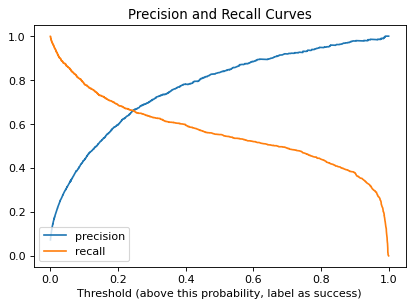

In [26]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgBoost.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as success)');
plt.title('Precision and Recall Curves');

In [27]:
from numpy import argmax
J = xgBoost_tpr - xgBoost_fpr
ix = argmax(J)
best_thresh = auc_thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.056627


In [54]:
def gen_confusion_matrix_2(model, threshold=0.056627):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:,1] >=threshold)
    cm = confusion_matrix(y_test, y_predict)
    
    plt.figure(figsize=(25,7))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='rocket_r', cbar=False, annot_kws={"size":20}, fmt='g')
    cmlabels = ['True Negatives', "False Positives",
               'False Negatives', "True Positives"]
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix - XGBoost', size=25)
    plt.xlabel('Predicted Application Outcome', size=20)
    plt.ylabel('Actual Application Outcome', size=20)
    labels = ['Approved', 'Declined']
    ax.set_xticklabels(labels, size=15)
    ax.set_yticklabels(labels, size=15)
    plt.tight_layout();

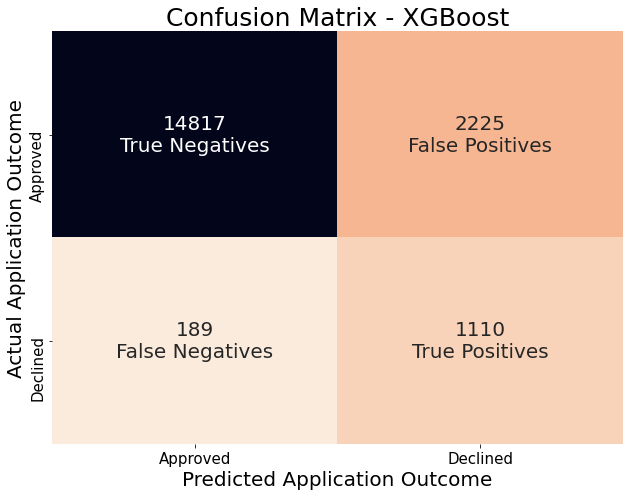

In [55]:
gen_confusion_matrix_2(xgBoost, threshold=0.056627)

##### precision = tp / (tp+fp) = 1110 / (1110 + 2225) = 1110 / 3335 = 0.33
##### recall = tp / (tp+fn) = 1110 / (1110 + 189) = 1110 / 1299 = 0.85
##### F1 = 2 * (precision * recall) / (precision + recall) = 0.48


In [56]:
# Visualize feature importance/contribution

xgb_full = xgb.DMatrix(X, label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

In [57]:
xgBoost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
params = dict(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
model = xgb.train(params, xgb_train, evals=[(xgb_test, "test")], verbose_eval=1000)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[09:41:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { importance_type, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-rmse:0.37459
[9]	test-rmse:0.18144


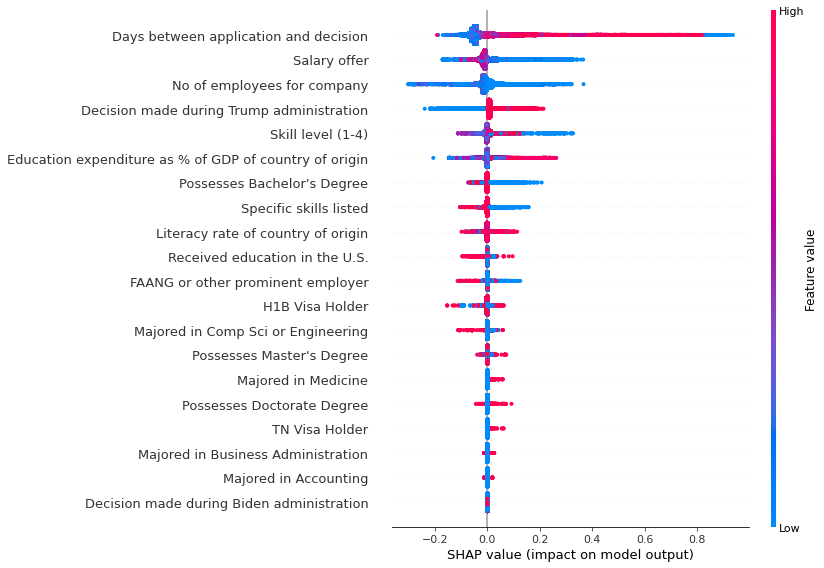

In [59]:
shap.summary_plot(shap_values, X)

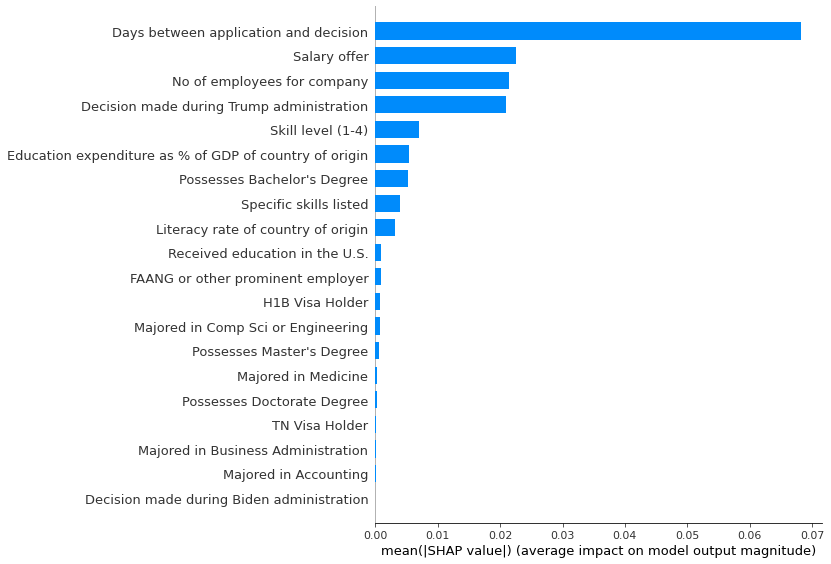

In [68]:
shap.summary_plot(shap_values, features=X, plot_type= "bar")